I wrote this notebook while learning about Variational Bayes & Variational Autoencoders in order to apply them to some agent designs in the MineRL Basalt 2021 Challenge. This implements a VAE in FastAI.jl/FluxML. The VAE in this notebook will then be used as part of a recurrent world model in the MineRL Basalt 2021 Challenge, and thus uses one of the demonstration videos. To obtain the data used in this notebook, go to [this link](https://minerl.io/dataset/) and follow the instructions for installing minerl in a Python virtual environment (miniconda recommended).

When the library is installed, open [sample-basalt-video-frames.ipynb](sample-basalt-video-frames.ipynb) and run the cells to get some frames of minecraft!

In [47]:
using CUDA
using FastAI
using FastAI: FluxTraining
using MLDataPattern
using Flux
using Flux.Zygote: Params
using Flux.Optimise: update!
using Statistics: mean
using StaticArrays
using Colors
using Images
import CairoMakie; CairoMakie.activate!(type="png")

A Variational Autoencoder is an unsupervised learning method, and as such, has no labels as in the supervised learning setting. We'll create versions of [BlockMethod](https://fluxml.ai/FastAI.jl/dev/docs/learning_methods.md.html) that support our needs, which include the datablock structure, which we appropriately pretty-print, along with infrastructure for plotting samples. Notebook is derived from: https://github.com/darsnack/fastai-vae-demo/blob/main/fastai-vae-nb.ipynb

In [4]:
function Base.show(io::IO, method::BlockMethod{<:FastAI.Block})
    print(io, "BlockMethod(", typeof(method.blocks), " -> ", typeof(method.blocks), ")")
end

In [5]:
function FastAI.BlockMethod(block::FastAI.Block, encodings; outputblock = FastAI.encodedblock(encodings, block))
    return BlockMethod(block, encodings, outputblock)
end

In [6]:
function FastAI.plotsample!(f, method::BlockMethod{<:FastAI.Block}, sample)
    blocks = (method.blocks, method.blocks)
    contexts = FastAI.plotcontext(blocks)
    FastAI.plotsample!(f, contexts, blocks, sample)
end

In [7]:
function FastAI.plotxy!(f, method::BlockMethod{<:FastAI.Block}, x, x̂)
    input, target = decode(
        method.encodings,
        Validation(),
        (method.outputblock, method.outputblock),
        (x, x̂))
    FastAI.plotsample!(f, method, (input, target))
end

In [8]:
FastAI.plotblock!(ax, ::Image{2}, data; kwargs...) = FastAI.plotimage!(ax, clamp01.(data); kwargs...)

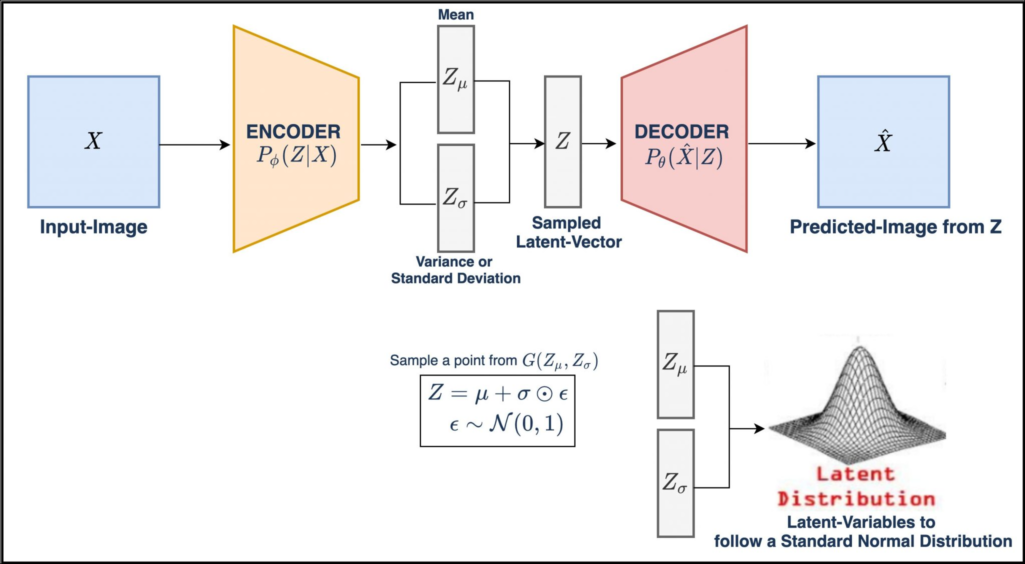

In [8]:
illustration_path = "/home/mu/src/WorldModels.jl/vae-diagram-1-2048x1126.jpg"
load(illustration_path)

In [135]:
# path = datasetpath("images")
data = Datasets.loadfolderdata(
    "images",
    filterfn = isimagefile,
    loadfn = (loadfile, parentname)
)

(mapobs(loadfile, ["images/makewaterfall-v0-0.jpg", "images/makewaterfall-v0-1.jpg", "images/makew…]), mapobs(parentname, ["images/makewaterfall-v0-0.jpg", "images/makewaterfall-v0-1.jpg", "images/makew…]))

In [136]:
data

(mapobs(loadfile, ["images/makewaterfall-v0-0.jpg", "images/makewaterfall-v0-1.jpg", "images/makew…]), mapobs(parentname, ["images/makewaterfall-v0-0.jpg", "images/makewaterfall-v0-1.jpg", "images/makew…]))

In [137]:
method = BlockMethod(
    Image{2}(),
    (ImagePreprocessing(means=SVector(0.0,), stds=SVector(1.), C=Gray{Float32})),
)

BlockMethod(Image{2} -> Image{2})

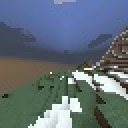

In [142]:
getobs(data[1], 3)

In [156]:
idxs = rand(1:nobs(data[1]), 9)

9-element Vector{Int64}:
 3891
   64
  104
 1946
 2492
  926
 3670
 2051
 2518

In [158]:
samples = [getobs(data[1], i) for i in idxs]
xs = makebatch(method, data[1], idxs)
ŷs = gpu(model)(gpu(xs)) |> cpu

LoadError: MethodError: objects of type NamedTuple{(:encoder, :decoder), Tuple{Chain{Tuple{Conv{2, 4, typeof(relu), CuArray{Float32, 4}, CuArray{Float32, 1}}, Conv{2, 4, typeof(relu), CuArray{Float32, 4}, CuArray{Float32, 1}}, Conv{2, 4, typeof(relu), CuArray{Float32, 4}, CuArray{Float32, 1}}, typeof(flatten), Dense{typeof(relu), CuArray{Float32, 2}, CuArray{Float32, 1}}, Dense{typeof(relu), CuArray{Float32, 2}, CuArray{Float32, 1}}, Parallel{typeof(tuple), Tuple{Dense{typeof(identity), CuArray{Float32, 2}, CuArray{Float32, 1}}, Dense{typeof(identity), CuArray{Float32, 2}, CuArray{Float32, 1}}}}}}, Chain{Tuple{Dense{typeof(relu), CuArray{Float32, 2}, CuArray{Float32, 1}}, Dense{typeof(relu), CuArray{Float32, 2}, CuArray{Float32, 1}}, Dense{typeof(relu), CuArray{Float32, 2}, CuArray{Float32, 1}}, Reshape, ConvTranspose{2, 4, typeof(relu), CuArray{Float32, 4}, CuArray{Float32, 1}}, ConvTranspose{2, 4, typeof(relu), CuArray{Float32, 4}, CuArray{Float32, 1}}, ConvTranspose{2, 4, typeof(identity), CuArray{Float32, 4}, CuArray{Float32, 1}}}}}} are not callable

In [143]:
size(getobs(data[1], 3))

(64, 64)

In [145]:
Din = prod(size(getobs(data[1], 1)))

4096

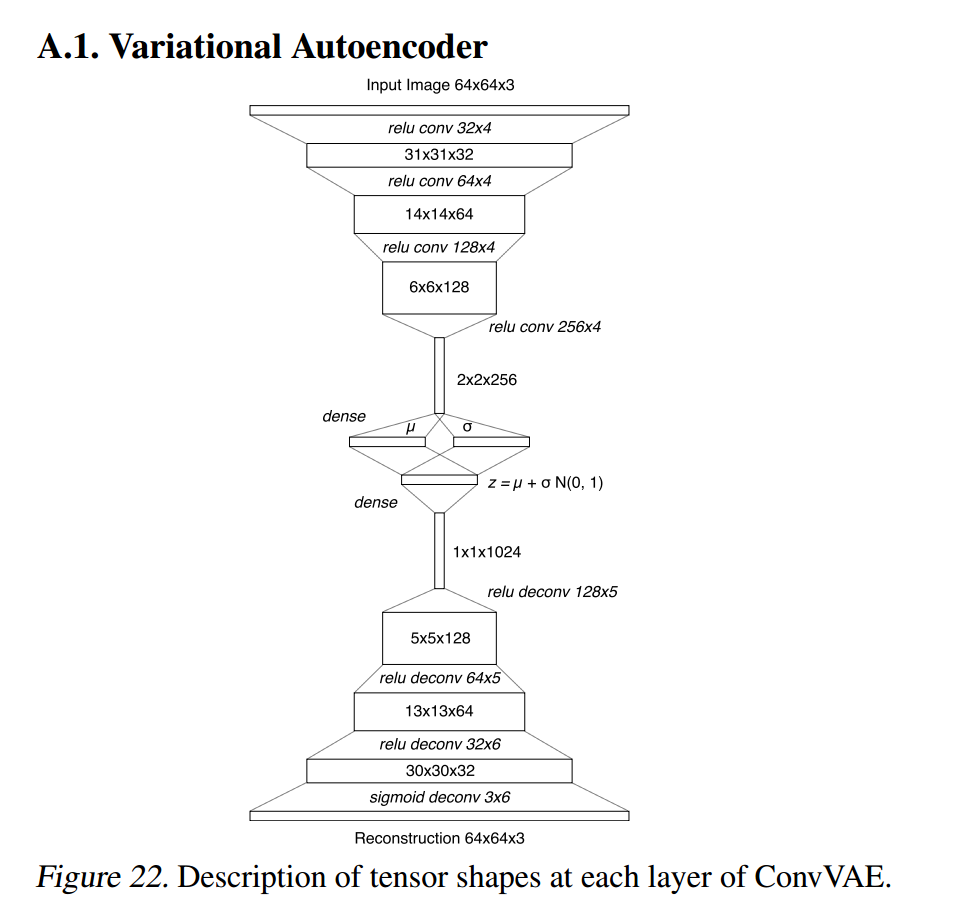

In [155]:
illustration_path = "/home/mu/src/WorldModels.jl/conv-vae-ha-schmidhuber.png"
load(illustration_path)

In [146]:
Dhidden = 256
Dlatent = 32
encoder = Chain(
    Conv((4, 4), 3 => 32, relu; stride=2, pad=1),
    Conv((4, 4), 32 => 32, relu; stride = 2, pad = 1),
    Conv((4, 4), 32 => 32, relu; stride = 2, pad = 1),
    Flux.flatten,
    Dense(32 * 4 * 4, Dhidden, relu),
    Dense(Dhidden, Dhidden, relu),
    Parallel(
        tuple,
        Dense(Dhidden, Dlatent), # μ
        Dense(Dhidden, Dlatent), # logσ² (logvar)
    )
) |> gpu

Chain(
  Conv((4, 4), 3 => 32, relu, pad=1, stride=2),  # 1_568 parameters
  Conv((4, 4), 32 => 32, relu, pad=1, stride=2),  # 16_416 parameters
  Conv((4, 4), 32 => 32, relu, pad=1, stride=2),  # 16_416 parameters
  Flux.flatten,
  Dense(512, 256, relu),                # 131_328 parameters
  Dense(256, 256, relu),                # 65_792 parameters
  Parallel(
    tuple,
    Dense(256, 32),                     # 8_224 parameters
    Dense(256, 32),                     # 8_224 parameters
  ),
)                   # Total: 14 arrays, 247_968 parameters, 1.789 KiB.

In [147]:
32*4*4

512

In [148]:
# define our own Reshape layer 
# (defined in [kastanos20fluxvae] here https://github.com/alecokas/flux-vae/blob/master/conv-vae/main.jl#L14)
struct Reshape
    shape
end

Reshape(args...) = Reshape(args)
(r::Reshape)(x) = reshape(x, r.shape)
Flux.@functor Reshape ()

In [149]:
decoder = Chain(
    Dense(Dlatent, Dhidden, relu),
    Dense(Dhidden, Dhidden, relu),
    Dense(Dhidden, 32 * 4 * 4, relu),
    Reshape(4, 4, 32, :),
    ConvTranspose((4, 4), 32 => 32, relu; stride = 2, pad = 1),
    ConvTranspose((4, 4), 32 => 32, relu; stride = 2, pad = 1),
    ConvTranspose((4, 4), 32 => 3; stride = 2, pad = 1)
) |> gpu

Chain(
  Dense(32, 256, relu),                 # 8_448 parameters
  Dense(256, 256, relu),                # 65_792 parameters
  Dense(256, 512, relu),                # 131_584 parameters
  Reshape((4, 4, 32, Colon())),
  ConvTranspose((4, 4), 32 => 32, relu, pad=1, stride=2),  # 16_416 parameters
  ConvTranspose((4, 4), 32 => 32, relu, pad=1, stride=2),  # 16_416 parameters
  ConvTranspose((4, 4), 32 => 3, pad=1, stride=2),  # 1_539 parameters
)                   # Total: 12 arrays, 240_195 parameters, 1.555 KiB.

Defining the loss function, known as Evidence Lower Bound (ELBO), and a utility to help us sample the latent space.

In [150]:
sample_latent(μ::AbstractArray{T}, logσ²::AbstractArray{T}) where T = 
    μ .+ exp.(logσ² ./ 2) .* randn(T, size(logσ²))

sample_latent (generic function with 2 methods)

In [151]:
sample_latent(μ::CuArray{T}, logσ²::CuArray{T}) where T = 
    μ .+ exp.(logσ² ./ 2) .* gpu(randn(T, size(logσ²)))

sample_latent (generic function with 2 methods)

In [152]:
function βELBO(x, x̄, μ, logσ²; β = 1)
    reconstruction_error = mean(sum(@.((x̄ - x)^2); dims=1))
    # D(N(μ, Σ)||N(0, I)) = 1/2 * (μᵀμ + tr(Σ) - length(μ) - log(|Σ|))
    kl_divergence = mean(sum(@.((μ^2 + exp(logσ²) - 1 - logσ²) / 2); dims = 1))
    return reconstruction_error + β * kl_divergence
end

βELBO (generic function with 1 method)

In [160]:
model = (encoder = encoder, decoder = decoder) |> gpu

(encoder = Chain(Conv((4, 4), 3 => 32, relu, pad=1, stride=2), Conv((4, 4), 32 => 32, relu, pad=1, stride=2), Conv((4, 4), 32 => 32, relu, pad=1, stride=2), flatten, Dense(512, 256, relu), Dense(256, 256, relu), Parallel(tuple, Dense(256, 32), Dense(256, 32))), decoder = Chain(Dense(32, 256, relu), Dense(256, 256, relu), Dense(256, 512, relu), Reshape((4, 4, 32, Colon())), ConvTranspose((4, 4), 32 => 32, relu, pad=1, stride=2), ConvTranspose((4, 4), 32 => 32, relu, pad=1, stride=2), ConvTranspose((4, 4), 32 => 3, pad=1, stride=2)))

In [162]:
using Metalhead
test_enc = Models.xresnet18()

Chain(
  Chain(
    Conv((3, 3), 3 => 32, pad=1, stride=2),  # 896 parameters
    BatchNorm(32, relu),                # 64 parameters, plus 64
  ),
  Chain(
    Conv((3, 3), 32 => 64, pad=1),      # 18_496 parameters
    BatchNorm(64, relu),                # 128 parameters, plus 128
  ),
  Chain(
    Conv((3, 3), 64 => 64, pad=1),      # 36_928 parameters
    BatchNorm(64, relu),                # 128 parameters, plus 128
  ),
  MaxPool((3, 3), pad=1, stride=2),
  Chain(
    ResBlock(
      Chain(
        Chain(
          Conv((3, 3), 64 => 64, pad=1),  # 36_928 parameters
          BatchNorm(64, relu),          # 128 parameters, plus 128
        ),
        Chain(
          Conv((3, 3), 64 => 64, pad=1),  # 36_928 parameters
          BatchNorm(64),                # 128 parameters, plus 128  (all zero)
        ),
      ),
      identity,
      identity,
    ),
    ResBlock(
      Chain(
        Chain(
          Conv((3, 3), 64 => 64, pad=1),  # 36_928 parameters
          BatchNorm(64, 

In [168]:
Flux.outputsize(encoder, (64, 64, 3, 32),)

┌ Error: layer Conv((4, 4), 3 => 32, relu, pad=1, stride=2), index 1 in Chain, gave an error with input of size (64, 64, 3, 32)
└ @ Flux /home/mu/.julia/packages/Flux/Zz9RI/src/outputsize.jl:107


LoadError: GPU compilation of kernel broadcast_kernel(CUDA.CuKernelContext, CuDeviceArray{Flux.NilNumber.Nil, 4, 1}, Base.Broadcast.Broadcasted{Nothing, NTuple{4, Base.OneTo{Int64}}, typeof(relu), Tuple{Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{4}, Nothing, typeof(+), Tuple{Base.Broadcast.Extruded{Array{Flux.NilNumber.Nil, 4}, NTuple{4, Bool}, NTuple{4, Int64}}, Base.Broadcast.Extruded{CuDeviceArray{Float32, 4, 1}, NTuple{4, Bool}, NTuple{4, Int64}}}}}}, Int64) failed
KernelError: passing and using non-bitstype argument

Argument 4 to your kernel function is of type Base.Broadcast.Broadcasted{Nothing, NTuple{4, Base.OneTo{Int64}}, typeof(relu), Tuple{Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{4}, Nothing, typeof(+), Tuple{Base.Broadcast.Extruded{Array{Flux.NilNumber.Nil, 4}, NTuple{4, Bool}, NTuple{4, Int64}}, Base.Broadcast.Extruded{CuDeviceArray{Float32, 4, 1}, NTuple{4, Bool}, NTuple{4, Int64}}}}}}, which is not isbits:
  .args is of type Tuple{Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{4}, Nothing, typeof(+), Tuple{Base.Broadcast.Extruded{Array{Flux.NilNumber.Nil, 4}, NTuple{4, Bool}, NTuple{4, Int64}}, Base.Broadcast.Extruded{CuDeviceArray{Float32, 4, 1}, NTuple{4, Bool}, NTuple{4, Int64}}}}} which is not isbits.
    .1 is of type Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{4}, Nothing, typeof(+), Tuple{Base.Broadcast.Extruded{Array{Flux.NilNumber.Nil, 4}, NTuple{4, Bool}, NTuple{4, Int64}}, Base.Broadcast.Extruded{CuDeviceArray{Float32, 4, 1}, NTuple{4, Bool}, NTuple{4, Int64}}}} which is not isbits.
      .args is of type Tuple{Base.Broadcast.Extruded{Array{Flux.NilNumber.Nil, 4}, NTuple{4, Bool}, NTuple{4, Int64}}, Base.Broadcast.Extruded{CuDeviceArray{Float32, 4, 1}, NTuple{4, Bool}, NTuple{4, Int64}}} which is not isbits.
        .1 is of type Base.Broadcast.Extruded{Array{Flux.NilNumber.Nil, 4}, NTuple{4, Bool}, NTuple{4, Int64}} which is not isbits.
          .x is of type Array{Flux.NilNumber.Nil, 4} which is not isbits.



In [118]:
opt = ADAM(1e-3)
dataiter = DataLoader(batchviewcollated(methoddataset(data[1], method, Training()), 32); buffered = false)
learner = Learner(model, (training = dataiter,), opt, βELBO, ToGPU())
FluxTraining.removecallback!(learner, ProgressPrinter)
;

LoadError: MethodError: no method matching iterate(::FastAI.Datasets.MappedData{typeof(loadfile), SubArray{String, 1, Vector{String}, Tuple{Vector{Int64}}, false}})
[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m) at range.jl:664
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Int64[39m) at range.jl:664
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{var"#s79", var"#s78"} where {var"#s79", var"#s78"<:Dict}, Base.ValueIterator{var"#s77"} where var"#s77"<:Dict} at dict.jl:693
[0m  ...

In [114]:
"""
VAETrainingPhase

Used to implement a custom training loop that takes our ELBO loss into account
"""
struct VAETrainingPhase <: FluxTraining.AbstractTrainingPhase end

VAETrainingPhase

In [115]:
function FluxTraining.step!(learner, phase::VAETrainingPhase, batch)
    FluxTraining.runstep(learner, phase, (x = batch,)) do handle, state
        ps = union(learner.params...)
        x = flatten(dropdims(state.x; dims = ndims(state.x)))
        gs = gradient(ps) do
            # get encode, sample latent, decode
            μ, logσ² = learner.model.encoder(x)
            z = sample_latent(μ, logσ²)
            x̄ = learner.model.decoder(z)
            handle(FluxTraining.LossBegin())
            state.loss = learner.lossfn(x, x̄, μ, logσ²)
            handle(FluxTraining.BackwardBegin())
            return state.loss
        end
        handle(FluxTraining.BackwardEnd())
        update!(learner.optimizer, ps, gs)
    end
end

In [116]:
function FluxTraining.on(::FluxTraining.StepBegin, ::VAETrainingPhase, cb::ToDevice, learner)
    learner.step.x = cb.movedatafn(learner.step.x)
end

### Training the model

In [117]:
for epoch in 1:30
    epoch!(learner, VAETrainingPhase())
end

LoadError: DimensionMismatch("Rank of x and w must match! (2 vs. 4)")